# Dimensionality reduction

> This notebook gets the embeddings (or latent space) from a multivariate time series 
given by a encoder (e.g., autoencoder) and uses them as input for a 
dimensionality reduction algorithm, to generate projectsion of the embeddings

In [40]:
from tsai.imports import *
from tsai.data.preparation import SlidingWindow
from fastcore.all import *
from dvats.all import *
import wandb
api = wandb.Api()
from yaml import load, FullLoader
import hdbscan

## Config parameters

Put here everything that could be needed if this notebook

In [41]:
config = AttrDict(
    use_wandb = False, # Whether to use or not wandb for experiment tracking
    wandb_group = None, # Whether to group this run in a wandb group
    wandb_entity = os.environ['WANDB_ENTITY'], # The entity to use for wandb,
    wandb_project = os.environ['WANDB_PROJECT'], # The project to use for wandb,
    dr_artifact_name = None, # * Set to None for using the default one (encoder validation set)
    enc_artifact = 'vrodriguezf90/deepvats/dcae:run-deepvats-tk702aqg', # Name:version of the encoder artifact
    n_neighbors = 15, #UMAP
    min_dist = 0.1, #UMAP,
    random_state = 1234 # UMAP
)

This model needs to restore the encoder model fitted in the notebook `02x`, as well as the data and configuration

## Run

In [42]:
run_dr = wandb.init(entity=config.wandb_entity,
                    project=config.wandb_project if config.use_wandb else 'work-nbs', 
                    group=config.wandb_group,
                    allow_val_change=True, 
                    job_type='dimensionality_reduction', 
                    mode='online' if config.use_wandb else 'disabled',
                    anonymous = 'never' if config.use_wandb else 'must',
                    config=config,
                    resume=False)
config_dr = wandb.config # Object for storing hyperparameters

In [43]:
# Botch to use artifacts offline
artifacts_gettr = run.use_artifact if config_dr.use_wandb else api.artifact

Restore the encoder model and its associated configuration

In [44]:
enc_artifact = artifacts_gettr(config.enc_artifact, type='learner')
enc_artifact.metadata

{'w': 24,
 'kss': [10, 5, 5],
 'nfs': [90, 60, 24],
 'ref': {'hash': '8408661268175229505',
  'type': "<class 'fastai.learner.Learner'>"},
 'delta': 24,
 'n_inp': 1,
 'top_k': 3,
 'device': 'cuda',
 'epochs': 200,
 'frozen': False,
 'stride': 1,
 'Learner': {'lr': 0.001,
  'wd': None,
  'moms': [0.95, 0.85, 0.95],
  'path': '.',
  '_name': '<fastai.learner.Learner object at 0x7f86182f7fa0>',
  'metrics': None,
  'opt_func': 'fastai.optimizer.Adam',
  'splitter': 'fastai.torch_core.trainable_params',
  'train_bn': True,
  'loss_func': 'MSELoss()',
  'model_dir': 'models',
  'wd_bn_bias': False,
  'default_cbs': True},
 'Recorder': {'add_time': True, 'train_metrics': False, 'valid_metrics': True},
 'pool_szs': [2, 3, 4],
 'use_wandb': True,
 'batch size': 64,
 'batch_size': 64,
 'frozen idx': 0,
 'valid_size': 0.1,
 'wandb_group': None,
 'CastToTensor': True,
 'dataset.tfms': '[ToFloat:\nencodes: (Tensor,object) -> encodes\n(object,object) -> encodes\ndecodes: (object,object) -> decodes\

In [45]:
# TODO: This only works when you run it two timeS! WTF?
try:
    enc_learner = enc_artifact.to_obj()
except:
    enc_learner = enc_artifact.to_obj()
enc_learner

wandb:   1 of 1 files downloaded.  


Restore the dataset artifact used for training the encoder. Even if we do not compute the dimensionality reduction over this dataset, we need to know the metadata of the encoder training set, to check that 
it matches with the dataset that we want to reduce.

In [49]:
enc_logger = enc_artifact.logged_by()
enc_artifact_train = artifacts_gettr(enc_logger.config['train_artifact'], type='dataset')
if enc_logger.config['valid_artifact'] is not None:
    enc_artifact_valid = artifacts_gettr(enc_logger.config['valid_artifact'], type='dataset')
enc_artifact_train.name, enc_artifact_valid.name

('toit:v0', 'toit:v0')

Now we specify the dataset artifact that we want to use for the reduction. If no artifact is defined, the artifact to reduce will be the one used for validate the encoder.

In [50]:
if config_dr.dr_artifact_name is not None:
    dr_artifact = artifacts_gettr(config_dr.dr_artifact_name)
else:
    dr_artifact = enc_artifact_valid
dr_artifact.name

'toit:v0'

Now we need to check whether the artifact that is going to be used fort the dimensionality reduction matches the artifact used to train the encoder. Matching means having the same number of variables, the same window size and stride, and the same frequency.

In [51]:
df = dr_artifact.to_df()
df

wandb:   1 of 1 files downloaded.  


,Piazza_Vanvitelli
2019-12-04 13:00:00,0.364095
2019-12-04 14:00:00,0.532166
2019-12-04 15:00:00,0.661551
2019-12-04 16:00:00,0.552637
2019-12-04 17:00:00,0.684569
...,...
2020-02-29 19:00:00,0.803531
2020-02-29 20:00:00,0.817342
2020-02-29 21:00:00,0.890509
2020-02-29 22:00:00,0.919360


In [52]:
df.shape

(2099, 1)

In [53]:
enc_input, _ = SlidingWindow(window_len=enc_logger.config['w'], 
                             stride=enc_logger.config['stride'], 
                             get_y=[])(df)
enc_input.shape

(2076, 1, 24)

### Getting the embeddings (activations) from the encoder

In [54]:
embs = get_enc_embs(enc_input, enc_learner, cpu=False)
test_eq(embs.shape[0], enc_input.shape[0])
embs.shape

(2076, 24)

Average embeddings in the time dimension, if needed

## Dimensionality reduction using UMAP

We use DR techniques to provide an alternative view for users to visually analyze and explore the time-series data. The algorithm UMAP shows its high competitiveness compared to t-SNE. t-SNE suffers from some limitations such as loss of large-scale information (the inter-cluster relationships). UMAP has a faster runtime and provides better scaling which helps to gain a meaningful organization of clusters, outliers and the preservation of continuums compared to t-SNE

For this part of the implementation, the package [umap-learn](https://github.com/lmcinnes/umap) is used. The input of the algoritm is the $n \times \delta$ that contains, for each slice of the time series, the corresponding $\delta$ latent embeddings given by the encoder.

The hyperparameters of UMAP are given values by default here. If the value has been already set previously, that means this notebook is being called from a wandb sweep, and we must use the value that the sweep is bringing.

In [55]:
umap_params = {
    'n_neighbors' : config_dr.n_neighbors,
    'min_dist' : config_dr.min_dist,
    'random_state': config_dr.random_state
}

In [56]:
prjs = get_UMAP_prjs(embs, cpu=False, **umap_params)
prjs.shape

(2076, 2)

Save the projections as an artifact

In [57]:
if config.use_wandb: 
    run.log_artifact(ReferenceArtifact(prjs, 'projections', type='projections', 
metadata=dict(run_dr.config)), aliases=f'run-{run.project}-{run.id}')

## Create Precomputed Clusters

In order to integrate precomputed clusters into the embedding space, it's necessary to log artifacts that include the labels of the newly created clusters. 

The cluster creation process is presented below. This creation procedure can be modified according to specific needs. However, the structure of the new artifact must be preserved (it must be a numpy.ndarray and the number of elements must be equal to the number of points in the embedding space).

In [ ]:
print(f'HDBSCAN supported metrics: {list(hdbscan.dist_metrics.METRIC_MAPPING.keys())}')

HDBSCAN supported metrics: ['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity', 'seuclidean', 'mahalanobis', 'wminkowski', 'hamming', 'canberra', 'braycurtis', 'matching', 'jaccard', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'haversine', 'cosine', 'arccos', 'pyfunc']


In [ ]:
# Define HDBSCAN parameters
hdbscan_kwargs = {
    'min_cluster_size' : 100,
    'min_samples' : 15,
    'cluster_selection_epsilon' : 0.08,
}
metric_kwargs = {
    'metric' : 'jaccard'
}

In [ ]:
# Create clusters using HDBSCAN
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs)
clusters_labels = clusters.labels_
clusters_labels

array([-1, -1, -1, ..., -1, -1, -1])

In [ ]:
# Testing artifact structure 
test_eq_type(type(clusters_labels), np.ndarray)
test_eq(clusters_labels.size, prjs.shape[0])

In [ ]:
# Create and log 'clusters_labels' artifact
clusters_ar = ReferenceArtifact(obj=clusters_labels, name='clusters_labels')
clusters_ar.metadata, clusters_ar.manifest.entries.values()

({'ref': {'hash': '1268660098414917857', 'type': "<class 'numpy.ndarray'>"}},
 dict_values([<ManifestEntry ref: file:///home/victor/data/wandb_artifacts/1268660098414917857/1268660098414917857>]))

In [ ]:
run_dr.log_artifact(clusters_ar, aliases=['hdbscan_jaccard'])

## 2D Visualization 

While the connected scatter plot is a simple visualization technique, it has very specific functions in our approach. Every sliding window is represented as a dot in the plot after the projection process (Fig. 4C, D of the paper). Before labeling, all points have the same color and transparency, and when they are concentrated in one area, the densities are accumulated. Lines are used to connect consecutive points preserving the temporal ordering of the data and allowing the user to see temporal connections (Fig. 4B of the paper). Thus, the point is linked to the previous point (inner) and to the posterior point (outer) as an indication of the flow of time.

In [58]:
#export
def plot_projections(prjs, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f}'.format(
        umap_params['n_neighbors'],umap_params['min_dist']))
    return ax

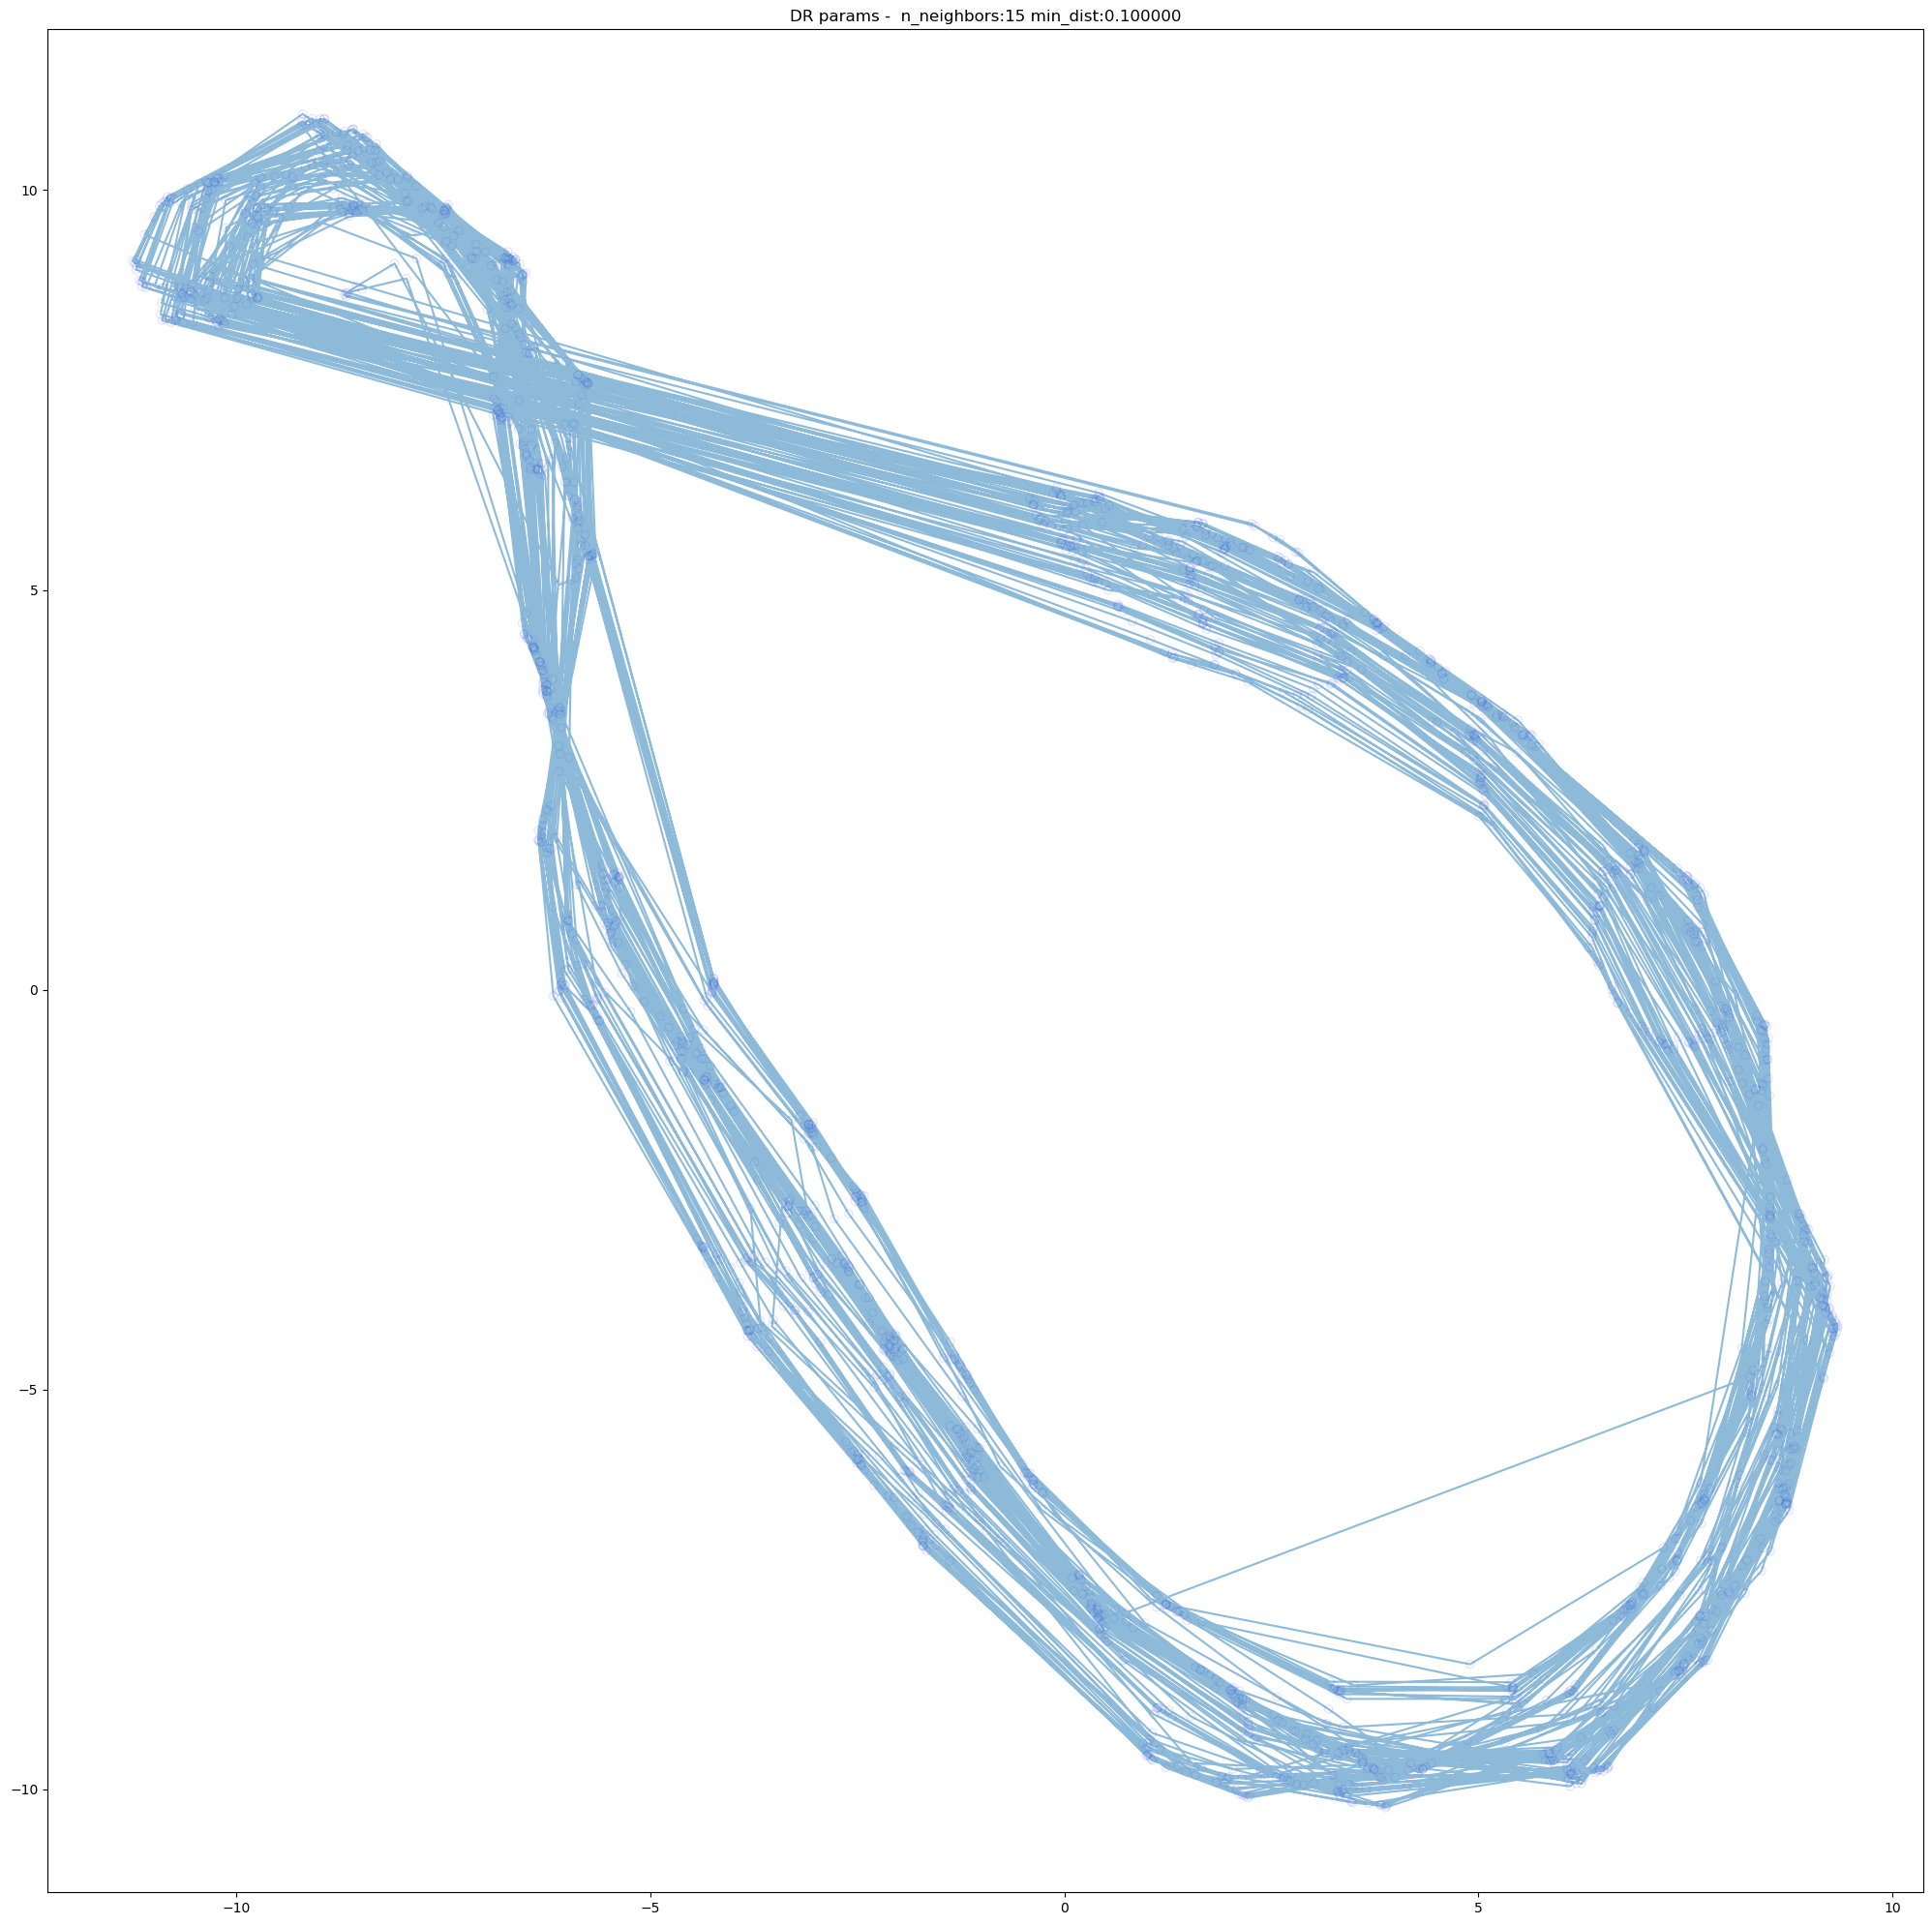

In [59]:
prjs_plt = plot_projections(prjs, umap_params)

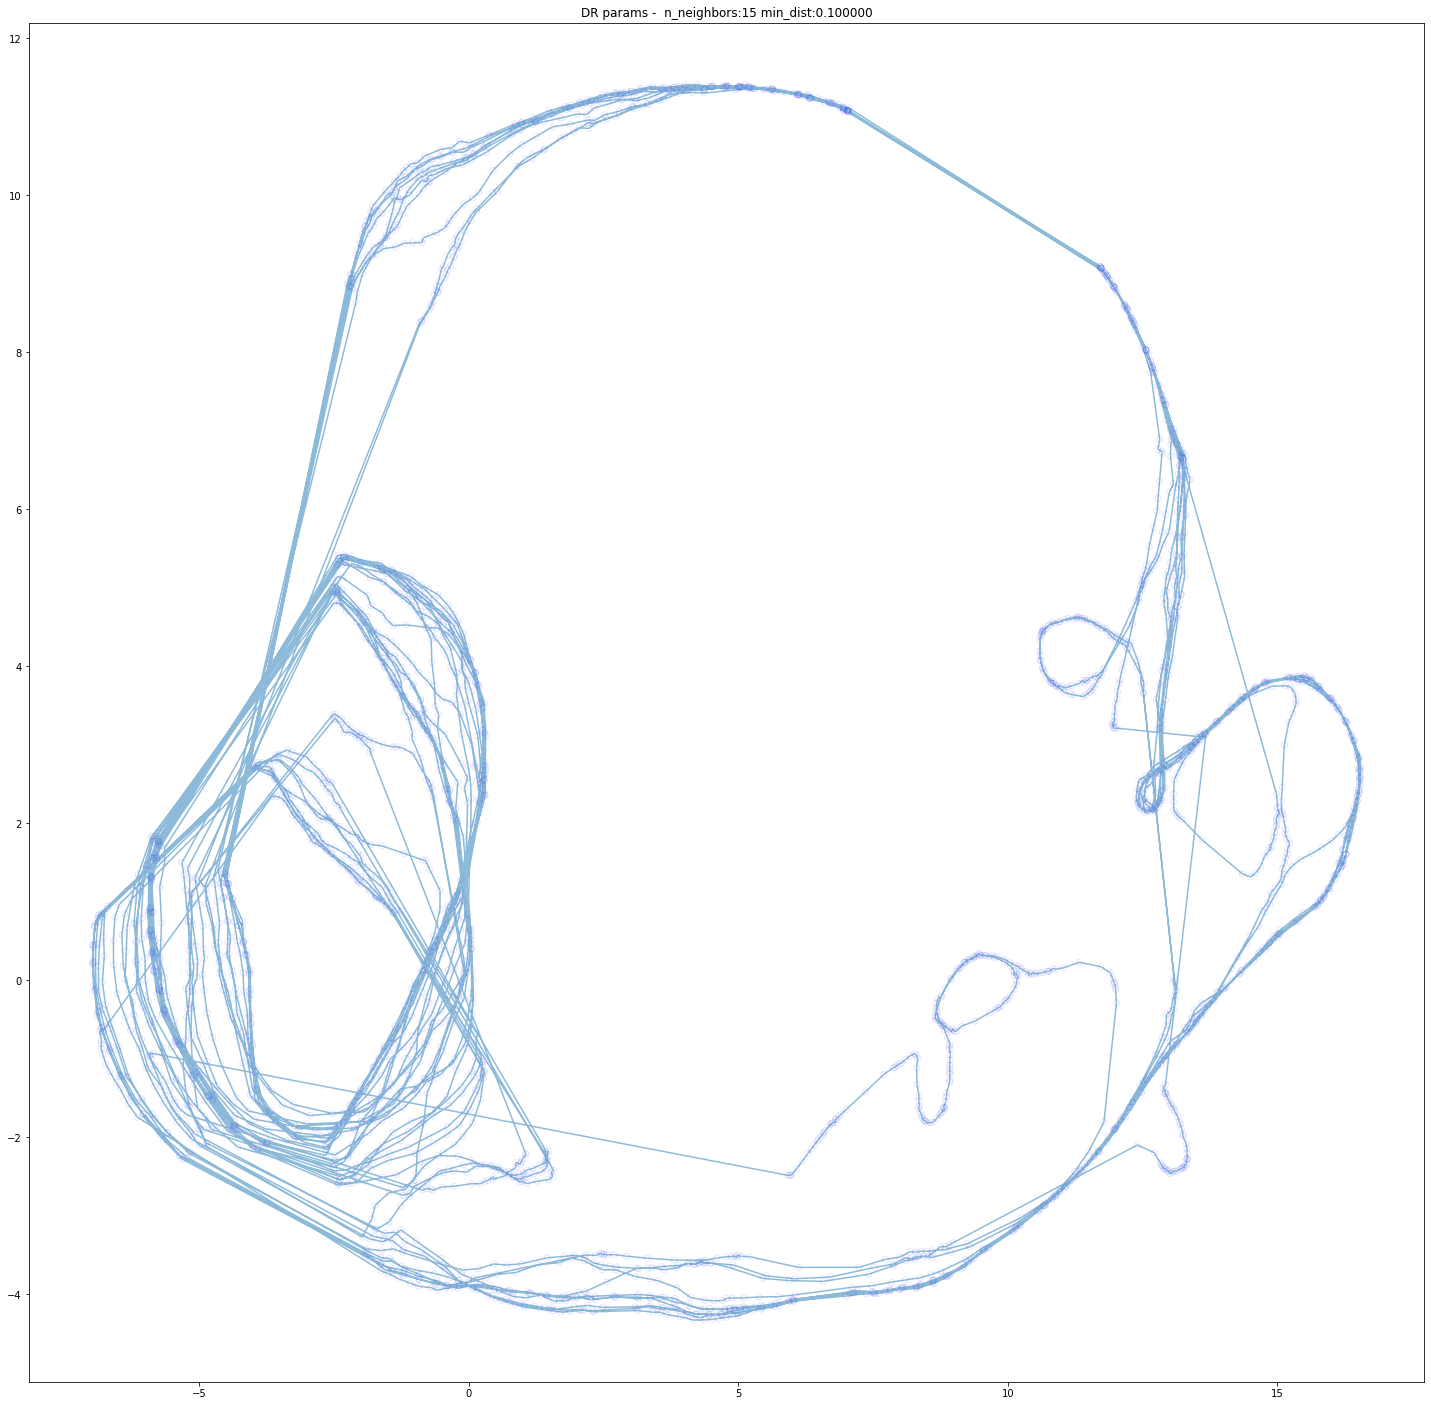

In [ ]:
prjs_plt = plot_projections(prjs, umap_params)

Log this plot as part of the current wandb run

In [ ]:
#hide

# Get the figure of the embedding plot, and save it on thea wandb run.
run_dr.log({"img": [wandb.Image(prjs_plt.get_figure(), caption="dr_projections_plot")]})

#run_dr.log({'embeddings_plot': embeddings_plot})

In [ ]:
#hide
run_dr.finish()

# Explainability with SHAP (future work)

In [ ]:
# %matplotlib inline

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111)

# ax.scatter(df_embeddings['x1'], df_embeddings['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
# ax.plot(df_embeddings['x1'], df_embeddings['x2'], alpha=0.5, picker=1)
# ax.set_title('Select the point you want to visualize as a time window in the original space')

Make the plot interactive to allow selection of subsets of the plot

In [ ]:
# selected_indices = None
# selected_points = None

# def onpick(event):
#     global selected_points
#     thisline = event.artist
#     xdata = thisline.get_xdata()
#     ydata = thisline.get_ydata()
#     global selected_indices
#     selected_indices = event.ind
#     selected_points = tuple(zip(xdata[selected_indices], ydata[selected_indices]))
#     print('onpick points (first):', selected_points[0])

# fig.canvas.mpl_connect('pick_event', onpick)

# plt.show()
# fig.tight_layout()
# fig.savefig(f'../img/w={w}.png')

## Hyperparameter tuning for the dimensionality reduction

There are a number of parameters that can be set for the UMAP algorithm. The major 
ones are `n_neighbors` and `min_dist`. Thus, we will carry out a hyperparameter 
sweep in Weights and Biases for these two parameters. Note that there is no objective
way of deciding that some embeddings are better than others. Thus, we must rely on our
intuition by visualizing the 2D plots of each of the runs in the sweep.

The first thing we need is gather all the pipeline of the previous section into a function


## Linking back points of the 2D projection to the original time series

The variable `selected_points` and `ind` contain an array of the points and indices selected in the previous 2D projection. We will take the first of them (there can be many selected points with just one click), and use its index to get the corresponding time window of the original space.

In [ ]:
# selected_window = input_data[df_embeddings.sample(n=1).index][0] if selected_indices is None else input_data[selected_indices[0]]
# selected_window

### Visualizing all the variables in the time window (default)

In [ ]:
# %matplotlib inline
# g = sns.FacetGrid(df_output_tidy, col="variable", col_wrap=3, aspect=2)
# g = g.map(plt.plot, "timestamp", "value")

### Contribution: Visualize only the most relevant variables

In high dimensional time series, not only is interesting to see the window associated to a point in the 2D space, but also it is extremely important to spot which variables are mainly causing that the window is positioned in that point of the 2D space.

Since UMAP does not provide capabilities to understand feature importance, there are [different ways](https://stats.stackexchange.com/questions/438025/understand-important-features-in-umap) to tackle this problem:

1. Use another dimensionality reduction technique that provides importance, such as [sparse PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html)

2. Create a surrogate model on top of the inputs/output of UMAP and explain it using XAI techniques. We will try here this option.

The idea is to have a surrogate model that takes the multivariate time series as input and produces the associated points in the 2D space as ouput. Since we already have a Deep Convolutional Autoencoder (DCAE) that takes a multivariate time series as input, and it contains the latent features that represent that input, we can use it for the surrogate. We will use the intermediate model that goes from the input to the layer containing the latent space, and then add a `Dense` layer with 2 units and linear activation.

In [ ]:
#export
# def train_surrogate_model(dcae, embeddings, lat_ln='latent_features'):
#     "Train a surrogate model that learns the `embeddings` from the latent features contained in the layer \
#     `lat_ln` of a previously trained Deep Convolutional AutoEncoder `dcae`"
#     x = dcae.get_layer(lat_ln).output
#     x = Dense(units=embeddings.shape[1], activation='linear')(x)
#     surrogate_model = Model(dcae.input, x)
#     l_nms = [layer.name for layer in surrogate_model.layers]
#     layer_idx = l_nms.index(lat_ln)
#     # The layers that are already trained from the autoencoder must be `frozen`
#     for layer in surrogate_model.layers[:layer_idx]:
#         layer.trainable = False
#     return surrogate_model

In [ ]:
# sm = train_surrogate_model(m, embeddings, lat_ln='latent_features')

In [ ]:
# test.equals(sm.input.shape, m.input.shape)
# test.equals(sm.output.shape[1], embeddings.shape[1])
# l_nms = [layer.name for layer in sm.layers]
# layer_idx = l_nms.index('latent_features')
# test.all_equal([layer.trainable for layer in sm.layers], \
#                np.repeat([False, True], [layer_idx + 1, len(sm.layers) -1 -layer_idx]))

Configure the training hyperparameters

In [ ]:
# loss = 'mean_squared_error'
# opt = 'adam'
# bs = 100
# epochs = 10
# val = .2

In [ ]:
# sm.output_shape

In [ ]:
# input_data.shape

In [ ]:
# embeddings.shape

In [ ]:
# sm.fit(x=input_data, y=embeddings, batch_size=bs, validation_split=val, epochs=epochs, callbacks=[WandbCallback()])

In [ ]:
# import innvestigate

In [ ]:
# analyzer = innvestigate.create_analyzer("gradient", intermediate_model)

In [ ]:
# asd= innvestigate.create_analyzer("gradient", m)

In [ ]:
# from keras.datasets import mnist

In [ ]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
# x_train.shape

In [ ]:
# input_data[np.random.choice(input_data.shape[0], 100, replace=False)].shape

In [ ]:
# import shap

In [ ]:
# background = input_data[np.random.choice(input_data.shape[0], 100, replace=False)]
# e = shap.DeepExplainer(intermediate_model, background)

In [ ]:
# shap_values = e.shap_values(input_data[0:4])

In [ ]:
# shap_values[0][0]